# Imports

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data gathering and preprocessing

## Movies

In [103]:
df_movies = pd.read_csv('../data/raw/movies.csv')

In [104]:
# clean table
df_movies.dropna(axis='index', subset=['year'], inplace=True)
df_movies.rename(columns={'id': 'movieID'}, inplace=True)
df_movies = df_movies.astype({'year': 'int32'})
df_movies.drop(['rtID', 'imdbPictureURL', 'rtPictureURL', 'spanishTitle'], axis=1, inplace=True)

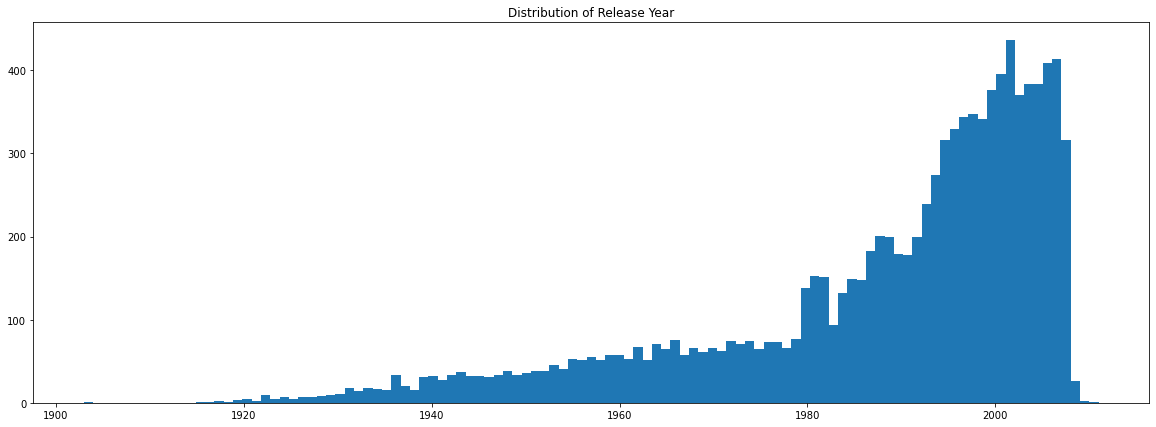

In [134]:
ax = plt.figure(figsize=(20,7))
ax = df_movies['year'].hist(bins=109)
ax.set(title='Distribution of Release Year')
ax.grid(False)
plt.show()

Die Filme stammen aus den Jahren 1903 bis 2011. Durch diese große Range sollte das Feature wertvoll für die Vorhersage sein. Die meisten Filme haben ein Veröffentlichungsdatum nach 1980.

In [100]:
df_movies = df_movies.astype({'year': 'str'})

### Movie Titles

In [16]:
movie_imdb_title = df_movies.loc[:, ['imdbID', 'title']]
movie_imdb_title.drop_duplicates(subset=['imdbID'], inplace=True)

### Movie IDs

In [17]:
movie_imdb = df_movies.loc[:, ['movieID', 'imdbID']]

In [18]:
# Funktion im movieID und imdbID ersetzen zu können -> wird nicht benötigt
def movieID_to_imdbID(movieID):
    if movieID in movie_imdb['movieID'].values:
        index = movie_imdb.loc[movie_imdb['movieID'] == movieID].index[0]
    else:
        return 'NaN'
    return movie_imdb.at[index, 'imdbID']

def imdbID_to_movieID(imdbID):
    if imdbID in movie_imdb['imdbID'].values:
        index = movie_imdb.loc[movie_imdb['imdbID'] == imdbID].index[0]
    else:
        return 'NaN'
    return movie_imdb.at[index, 'movieID']

## Actor
Wenn Animationsfilm -> Schauspieler weglassen?
-> Was passiert dann bei 'Hybriden', e.g. Avatar oder sowas?

In [116]:
df_actors = pd.read_csv('../data/raw/actors.csv')

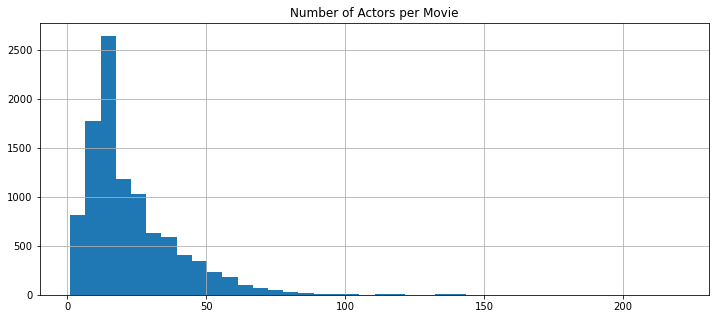

In [125]:
plt.figure(figsize=(12,5))
ax = df_actors.groupby('movieID').count()['ranking'].hist(bins=40)
ax.set(title='Number of Actors per Movie')
plt.show()

Bei vielen Filmen sind relativ viele Schauspieler zugeordnet. Da wir für alle Filme gleich viele Schauspieler berücksichtigen wollen und Nebendarsteller für viele Nutzer wenig relevant sein sollten, verwenden wir im Folgenden nur die 3 Schauspieler, die im Abspann zuerst genannt wurden.

In [20]:
# Nur die drei Hauptschauspieler
df_actors.drop(df_actors[ df_actors['ranking'] > 3 ].index , inplace=True)

In [21]:
df_test = df_actors[df_actors['ranking']==1]['movieID'].value_counts()
df_test = pd.DataFrame(df_test)

In [22]:
df_test[df_test['movieID'] > 1]

,movieID
62970,49
26649,40
6167,29
6840,27
5475,26
...,...
787,3
3530,3
7415,3
5143,2


In [23]:
df_actors = df_actors.drop_duplicates(subset=['movieID','ranking'])

In [24]:
# In DataFrame anhand der MovieID umwandeln
df_movies_actor = pd.DataFrame(df_actors['movieID'].drop_duplicates())

df_movies_actor = df_movies_actor.merge(df_actors.loc[df_actors['ranking']==1,['movieID','actorID']], on='movieID',how='left')
df_movies_actor = df_movies_actor.rename(columns={"actorID": "actor1"})
df_movies_actor = df_movies_actor.merge(df_actors.loc[df_actors['ranking']==2,['movieID','actorID']], on='movieID',how='left')
df_movies_actor = df_movies_actor.rename(columns={"actorID": "actor2"})
df_movies_actor = df_movies_actor.merge(df_actors.loc[df_actors['ranking']==3,['movieID','actorID']], on='movieID',how='left')
df_movies_actor = df_movies_actor.rename(columns={"actorID": "actor3"})
df_movies_actor

,movieID,actor1,actor2,actor3
0,1,tom_hanks,tim_allen,don_rickles
1,2,robin_williams,bonnie_hunt,kirsten_dunst
2,3,jack_lemmon,walter_matthau,annmargret
3,4,whitney_houston,angela_bassett,loretta_devine
4,5,steve_martin,diane_keaton,martin_short
...,...,...,...,...
10169,65088,adam_sandler,keri_russell,guy_pearce
10170,65091,clark_gable,william_powell,myrna_loy
10171,65126,sam_rockwell,anjelicahuston,kelly_macdonald
10172,65130,leonardo_di_caprio,kate_winslet,kathy_bates


In [25]:
# check for null
for col in df_movies_actor.columns:
    print(col, ": ", df_movies_actor[col].isna().sum())

movieID :  0
actor1 :  0
actor2 :  435
actor3 :  492


## Countries

In [27]:
df_countries = pd.read_csv('../data/raw/countries.csv')

In [28]:
# check for null
for col in df_countries.columns:
    print(col, ": ", df_countries[col].isna().sum())

movieID :  0
country :  8


In [29]:
df_countries['movieID'].value_counts()

2047     1
7457     1
5424     1
62764    1
3371     1
        ..
4751     1
6798     1
653      1
2700     1
2049     1
Name: movieID, Length: 10197, dtype: int64

Kein Movie hat mehrere Länder

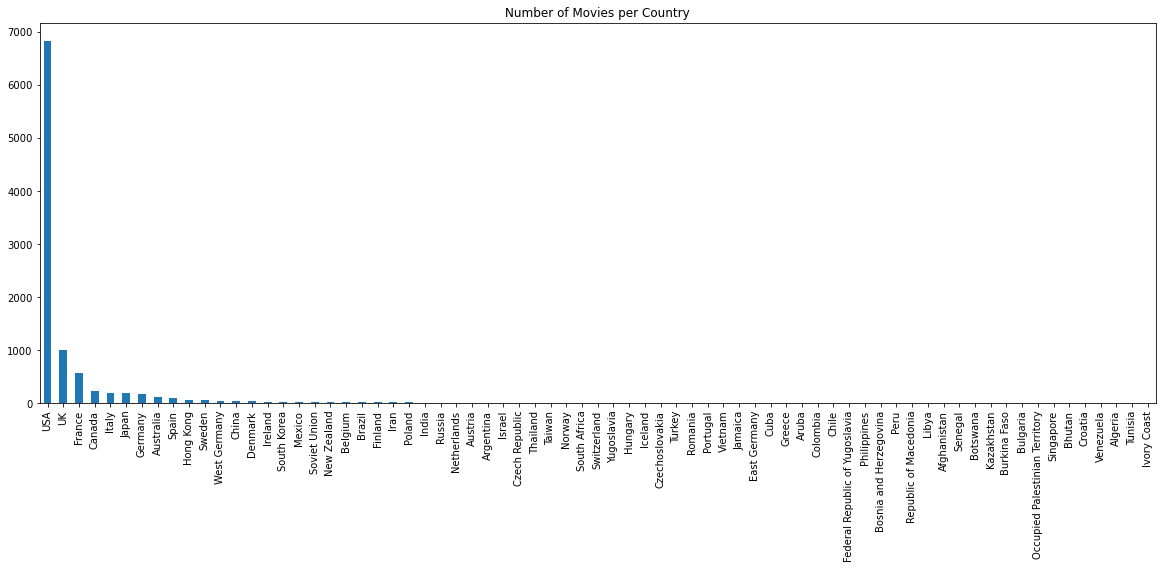

In [127]:
plt.figure(figsize=(20,7))
ax = df_countries['country'].value_counts().plot(kind='bar')
ax.set(title='Number of Movies per Country')
plt.show()

Jedem Film ist genau ein Produktionsland zugeordnet. Zwei Drittel der Filme kommen aus den USA, was die Aussagekraft des Merkmals etwas einschränkt. Dennoch verwenden wir das Merkmal, um spezielle Herstellungsländer wie Frankreich oder Japan zu berücksichtigen.

## Directors

In [130]:
df_directors = pd.read_csv('../data/raw/directors.csv')

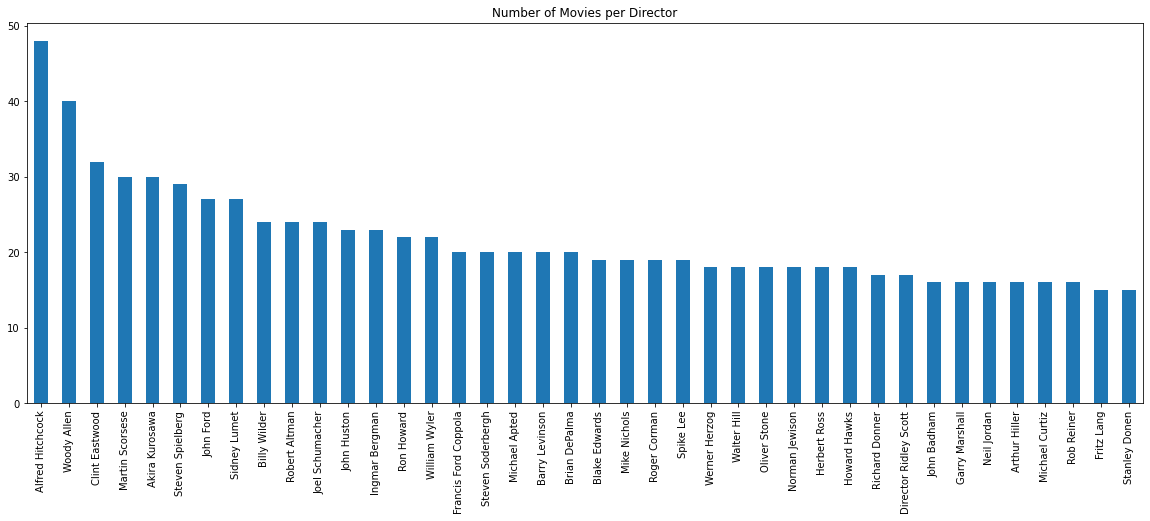

In [133]:
plt.figure(figsize=(20,7))
ax = df_directors['directorName'].value_counts()[:40].plot(kind='bar')
ax.set(title='Number of Movies per Director')
plt.show()

Viele Regisseure haben bei mehreren Filmen Regie geführt. Daher werden bei einem User, der Filme eines Regisseurs regelmäßig gut bewertet, für andere Filme des Regisseurs tendenziell eine gute Bewertung vorhergesagt.

In [31]:
# check for null
for col in df_directors.columns:
    print(col, ": ", df_directors[col].isna().sum())

movieID :  0
directorID :  0
directorName :  0


In [32]:
df_directors.drop('directorName', axis=1, inplace=True)

## Genre

In [33]:
df_genres = pd.read_csv('../data/raw/genres.csv')

In [34]:
# check for null
for col in df_genres.columns:
    print(col, ": ", df_genres[col].isna().sum())

movieID :  0
genre :  0


In [35]:
df_genres["movieID"].value_counts()

51709    8
2987     7
56152    7
46948    7
673      6
        ..
4988     1
7751     1
3653     1
3637     1
4286     1
Name: movieID, Length: 10197, dtype: int64

Filme haben bis zu 8 Genres

In [36]:
df_genres_all = pd.DataFrame(columns = ['movieID', 'genre'])
df_genres_all['movieID'] = df_genres["movieID"].value_counts().index
# Wird nur benötigt im in der nächsten Schleife Strings addieren zu können
for index, row in df_genres_all.iterrows():
    df_genres_all.at[index, 'genre']= ""

In [37]:
for index, row in df_genres.iterrows():
    df_genres_all.at[df_genres_all[df_genres_all['movieID']==df_genres.at[index, 'movieID']].index[0],'genre'] = df_genres_all.at[df_genres_all[df_genres_all['movieID']==df_genres.at[index, 'movieID']].index[0],'genre']+ " " + df_genres.at[index, 'genre']
df_genres_all

,movieID,genre
0,51709,Action Adventure Comedy Drama Fantasy Horror ...
1,2987,Adventure Animation Children Comedy Crime Fan...
2,56152,Adventure Animation Children Comedy Fantasy M...
3,46948,Adventure Animation Children Comedy Drama Fan...
4,673,Adventure Animation Children Comedy Fantasy S...
...,...,...
10192,4988,Adventure
10193,7751,Drama
10194,3653,Documentary
10195,3637,Drama


Möglicherweise sind zu viele Filme den Genres "Drama" und "Comedy" zugeordnet. Dort sind 50% bzw. 36% der Filme enthalten, was die Aussagekraft dieses Merkmals verschlechtern könnte.

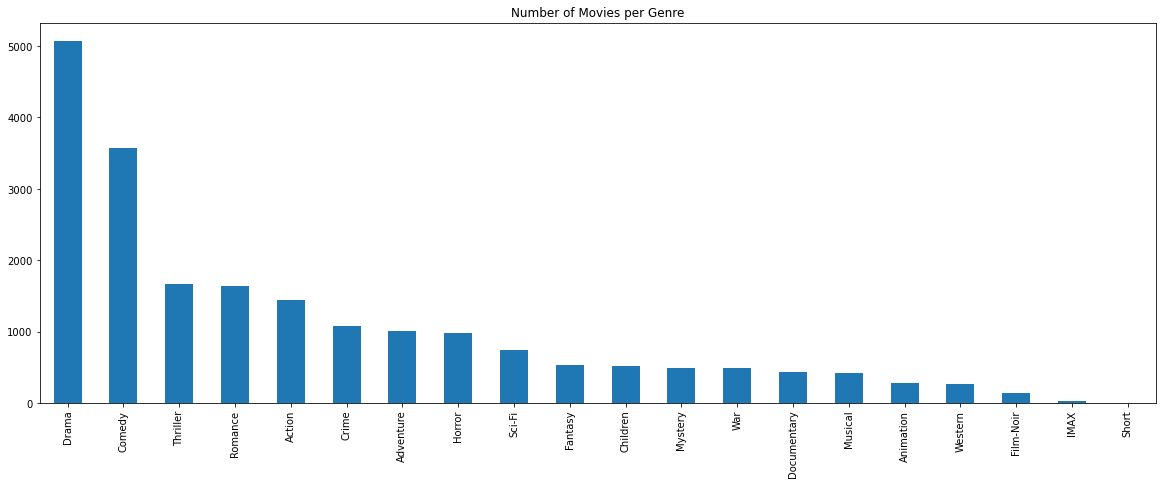

In [135]:
plt.figure(figsize=(20,7))
ax = df_genres['genre'].value_counts().plot(kind='bar')
ax.set(title='Number of Movies per Genre')
plt.show()

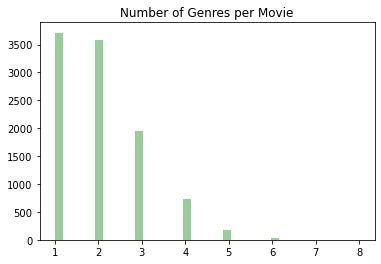

In [89]:
ax = sns.distplot(df_genres.groupby('movieID').count(), hist_kws={'color': 'g'}, kde=False)
ax.set(title='Number of Genres per Movie')
plt.show()

In [72]:
df_genres.groupby('movieID').count()

,genre
movieID,
1,5
2,3
3,2
4,3
5,1
...,...
65088,3
65091,3
65126,2


## Rating

In [38]:
df_ratings = pd.read_csv('../data/raw/ratings.csv')

In [39]:
# check for null
for col in df_ratings.columns:
    print(col, ": ", df_ratings[col].isna().sum())

user_id :  0
movieID :  0
rating :  0


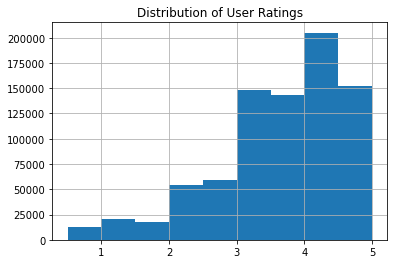

In [91]:
ax = df_ratings['rating'].hist(bins=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set(title="Distribution of User Ratings")
plt.show()

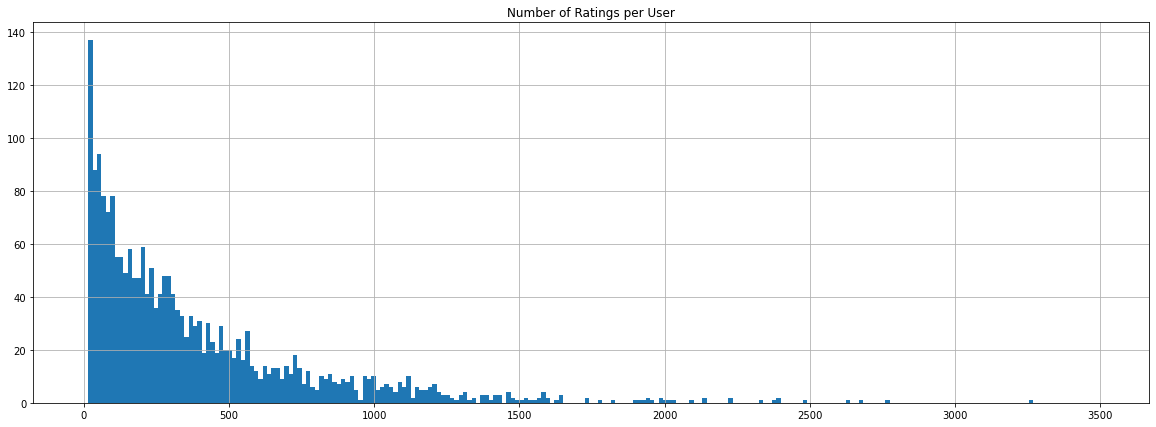

In [146]:
plt.figure(figsize=(20,7))
ax = df_ratings.groupby('user_id').count()['rating'].hist(bins=np.arange(0,3500,15))
ax.set(title="Number of Ratings per User")
plt.show()

In [42]:
movies_rating = df_movies.merge(df_ratings, on='movieID')
movies_rating

,movieID,title,imdbID,year,user_id,rating
0,1,Toy story,114709,1995,1339,5.0
1,1,Toy story,114709,1995,551,3.5
2,1,Toy story,114709,1995,336,4.5
3,1,Toy story,114709,1995,1087,3.5
4,1,Toy story,114709,1995,1598,4.0
...,...,...,...,...,...,...
812718,65126,Choke,1024715,2008,599,3.5
812719,65130,Revolutionary Road,959337,2008,817,2.5
812720,65133,Blackadder Back & Forth,212579,1999,1059,4.0
812721,65133,Blackadder Back & Forth,212579,1999,480,5.0


In [43]:
ratings = pd.DataFrame(movies_rating.groupby('movieID')['rating'].mean())
ratings['number_of_ratings'] = movies_rating.groupby('movieID')['rating'].count()
#ratings = ratings.merge(movie_imdb_title, on='movieID')
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
movieID,,
2571,4.173927,1584
4993,4.081380,1493
356,3.929577,1491
5952,4.032899,1459
296,4.241935,1457
2858,4.111151,1399
7153,4.083632,1393
318,4.365497,1368
2959,4.258419,1366


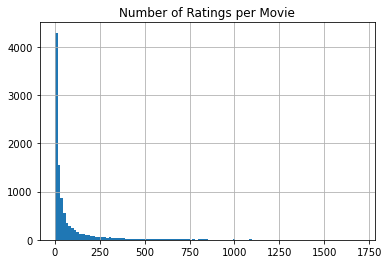

In [147]:
ax = df_ratings.groupby('movieID').count()['rating'].hist(bins=np.arange(0,1700,15))
ax.set(title='Number of Ratings per Movie')
plt.show()

In [155]:
df_movies[df_movies['movieID']==2571]

,movieID,title,imdbID,year
2350,2571,The Matrix,133093,1999


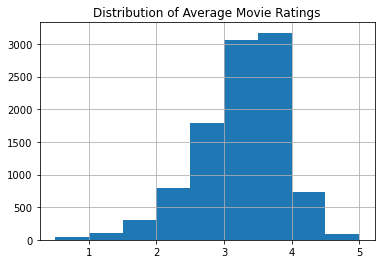

In [158]:
ax = ratings['rating'].hist(bins=np.arange(0.5,5.5,0.5))
ax.set(title="Distribution of Average Movie Ratings")
plt.show()

## Runtime

In [50]:
df_runtime = pd.read_csv('../data/raw/runtime.csv')
df_runtime.drop(['Runtime', 'runtime_min'], axis = 1, inplace = True)
df_runtime

,movieID,runtime_cat
0,1,length_normal
1,2,length_normal
2,3,length_normal
3,4,length_excess
4,5,length_normal
...,...,...
10192,65088,length_normal
10193,65091,length_normal
10194,65126,length_normal
10195,65130,length_normal


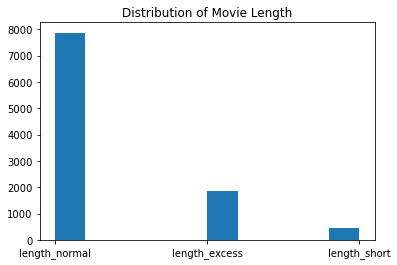

In [63]:
ax = df_runtime['runtime_cat'].hist(align='mid')
ax.grid(False)
ax.set(title="Distribution of Movie Length")
plt.show()

# Merging DataFrame

In [59]:
df_test = pd.DataFrame(df_movies['imdbID'].value_counts())
df_test[df_test['imdbID']>1]
# es gibt 689 Filme (imdbIDs) die unterschiedliche movieIDs haben (bis zu 6), z.b. imdbId 116477

,imdbID
116477,6
293508,5
163978,4
360717,4
398913,4
...,...
53291,2
118787,2
89604,2
61512,2


In [60]:
movies = pd.merge(df_movies, df_movies_actor, on='movieID', how='left')
print ("Loosing {} movies due to adding Actors.".format(len(df_movies['imdbID'].value_counts())-len(movies['imdbID'].value_counts())))
movies = pd.merge(movies, df_countries, on='movieID', how='left')
print ("Loosing {} movies due to adding Countries.".format(len(df_movies['imdbID'].value_counts())-len(movies['imdbID'].value_counts())))
movies = pd.merge(movies, df_directors, on='movieID', how='left')
print ("Loosing {} movies due to adding Directors.".format(len(df_movies['imdbID'].value_counts())-len(movies['imdbID'].value_counts())))
movies = pd.merge(movies, df_genres_all, on='movieID', how='left')
print ("Loosing {} movies due to adding Genres.".format(len(df_movies['imdbID'].value_counts())-len(movies['imdbID'].value_counts())))
movies = pd.merge(movies, df_runtime, on='movieID', how='left')
print ("Loosing {} movies due to adding Runtime.".format(len(df_movies['imdbID'].value_counts())-len(movies['imdbID'].value_counts())))
print(movies.shape)
movies

Loosing 0 movies due to adding Actors.
Loosing 0 movies due to adding Countries.
Loosing 0 movies due to adding Directors.
Loosing 0 movies due to adding Genres.
Loosing 0 movies due to adding Runtime.
(14335, 11)


,movieID,title,imdbID,year,actor1,actor2,actor3,country,directorID,genre,runtime_cat
0,1,Toy story,114709,1995,tom_hanks,tim_allen,don_rickles,USA,john_lasseter,Adventure Animation Children Comedy Fantasy,length_normal
1,2,Jumanji,113497,1995,robin_williams,bonnie_hunt,kirsten_dunst,USA,joe_johnston,Adventure Children Fantasy,length_normal
2,3,Grumpy Old Men,107050,1993,jack_lemmon,walter_matthau,annmargret,USA,donald_petrie,Comedy Romance,length_normal
3,4,Waiting to Exhale,114885,1995,whitney_houston,angela_bassett,loretta_devine,USA,forest_whitaker,Comedy Drama Romance,length_excess
4,5,Father of the Bride Part II,113041,1995,steve_martin,diane_keaton,martin_short,USA,charles_shyer,Comedy,length_normal
...,...,...,...,...,...,...,...,...,...,...,...
14330,65088,Bedtime Stories,960731,2008,adam_sandler,keri_russell,guy_pearce,USA,adam_shankman,Adventure Children Comedy,length_normal
14331,65091,Manhattan Melodrama,25464,1934,clark_gable,william_powell,myrna_loy,USA,ws_van_dyke,Crime Drama Romance,length_normal
14332,65126,Choke,1024715,2008,sam_rockwell,anjelicahuston,kelly_macdonald,USA,clark_gregg,Comedy Drama,length_normal
14333,65130,Revolutionary Road,959337,2008,leonardo_di_caprio,kate_winslet,kathy_bates,USA,sam_mendes,Drama Romance,length_normal


In [61]:
for col in movies.columns:
    print(col, ": ", movies[col].isna().sum())

movieID :  0
title :  0
imdbID :  0
year :  0
actor1 :  23
actor2 :  4600
actor3 :  4657
country :  40
directorID :  347
genre :  0
runtime_cat :  37


In [62]:
#Round Year
movies['rounded_year'] = movies['year'].astype(int)
movies['rounded_year']= movies['rounded_year']/10
movies['rounded_year'] = movies['rounded_year'].astype(int)*10
movies

,movieID,title,imdbID,year,actor1,actor2,actor3,country,directorID,genre,runtime_cat,rounded_year
0,1,Toy story,114709,1995,tom_hanks,tim_allen,don_rickles,USA,john_lasseter,Adventure Animation Children Comedy Fantasy,length_normal,1990
1,2,Jumanji,113497,1995,robin_williams,bonnie_hunt,kirsten_dunst,USA,joe_johnston,Adventure Children Fantasy,length_normal,1990
2,3,Grumpy Old Men,107050,1993,jack_lemmon,walter_matthau,annmargret,USA,donald_petrie,Comedy Romance,length_normal,1990
3,4,Waiting to Exhale,114885,1995,whitney_houston,angela_bassett,loretta_devine,USA,forest_whitaker,Comedy Drama Romance,length_excess,1990
4,5,Father of the Bride Part II,113041,1995,steve_martin,diane_keaton,martin_short,USA,charles_shyer,Comedy,length_normal,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
14330,65088,Bedtime Stories,960731,2008,adam_sandler,keri_russell,guy_pearce,USA,adam_shankman,Adventure Children Comedy,length_normal,2000
14331,65091,Manhattan Melodrama,25464,1934,clark_gable,william_powell,myrna_loy,USA,ws_van_dyke,Crime Drama Romance,length_normal,1930
14332,65126,Choke,1024715,2008,sam_rockwell,anjelicahuston,kelly_macdonald,USA,clark_gregg,Comedy Drama,length_normal,2000
14333,65130,Revolutionary Road,959337,2008,leonardo_di_caprio,kate_winslet,kathy_bates,USA,sam_mendes,Drama Romance,length_normal,2000


# Save preprocessed DataFrames

In [63]:
movies.to_csv(
    '../data/preprocessed/movies.csv')
df_ratings.to_csv(
    '../data/preprocessed/df_ratings.csv')

# First Model

In [64]:
movies_reduced = movies.copy()
movies_reduced

,movieID,title,imdbID,year,actor1,actor2,actor3,country,directorID,genre,runtime_cat,rounded_year
0,1,Toy story,114709,1995,tom_hanks,tim_allen,don_rickles,USA,john_lasseter,Adventure Animation Children Comedy Fantasy,length_normal,1990
1,2,Jumanji,113497,1995,robin_williams,bonnie_hunt,kirsten_dunst,USA,joe_johnston,Adventure Children Fantasy,length_normal,1990
2,3,Grumpy Old Men,107050,1993,jack_lemmon,walter_matthau,annmargret,USA,donald_petrie,Comedy Romance,length_normal,1990
3,4,Waiting to Exhale,114885,1995,whitney_houston,angela_bassett,loretta_devine,USA,forest_whitaker,Comedy Drama Romance,length_excess,1990
4,5,Father of the Bride Part II,113041,1995,steve_martin,diane_keaton,martin_short,USA,charles_shyer,Comedy,length_normal,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
14330,65088,Bedtime Stories,960731,2008,adam_sandler,keri_russell,guy_pearce,USA,adam_shankman,Adventure Children Comedy,length_normal,2000
14331,65091,Manhattan Melodrama,25464,1934,clark_gable,william_powell,myrna_loy,USA,ws_van_dyke,Crime Drama Romance,length_normal,1930
14332,65126,Choke,1024715,2008,sam_rockwell,anjelicahuston,kelly_macdonald,USA,clark_gregg,Comedy Drama,length_normal,2000
14333,65130,Revolutionary Road,959337,2008,leonardo_di_caprio,kate_winslet,kathy_bates,USA,sam_mendes,Drama Romance,length_normal,2000


In [ ]:
movies_reduced['rounded_year'] = movies_reduced['year'].astype(int)
movies_reduced['rounded_year']= movies_reduced['rounded_year']/10
movies_reduced['rounded_year'] = movies_reduced['rounded_year'].astype(int)*10
movies_reduced

In [65]:
movies_reduced.fillna('', inplace=True)

,movieID,title,imdbID,year,actor1,actor2,actor3,country,directorID,genre,runtime_cat,rounded_year
0,1,Toy story,114709,1995,tom_hanks,tim_allen,don_rickles,USA,john_lasseter,Adventure Animation Children Comedy Fantasy,length_normal,1990
1,2,Jumanji,113497,1995,robin_williams,bonnie_hunt,kirsten_dunst,USA,joe_johnston,Adventure Children Fantasy,length_normal,1990
2,3,Grumpy Old Men,107050,1993,jack_lemmon,walter_matthau,annmargret,USA,donald_petrie,Comedy Romance,length_normal,1990
3,4,Waiting to Exhale,114885,1995,whitney_houston,angela_bassett,loretta_devine,USA,forest_whitaker,Comedy Drama Romance,length_excess,1990
4,5,Father of the Bride Part II,113041,1995,steve_martin,diane_keaton,martin_short,USA,charles_shyer,Comedy,length_normal,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
14330,65088,Bedtime Stories,960731,2008,adam_sandler,keri_russell,guy_pearce,USA,adam_shankman,Adventure Children Comedy,length_normal,2000
14331,65091,Manhattan Melodrama,25464,1934,clark_gable,william_powell,myrna_loy,USA,ws_van_dyke,Crime Drama Romance,length_normal,1930
14332,65126,Choke,1024715,2008,sam_rockwell,anjelicahuston,kelly_macdonald,USA,clark_gregg,Comedy Drama,length_normal,2000
14333,65130,Revolutionary Road,959337,2008,leonardo_di_caprio,kate_winslet,kathy_bates,USA,sam_mendes,Drama Romance,length_normal,2000


In [66]:
movies_reduced.fillna('', inplace=True)

In [67]:
# Die folgenden Spalten werden bei der Bestimmung der Ähnlichkeit betrachtet
# und in 'all_in_all' gespeichert
# Director wird doppelt gewichtet
movies_reduced['all_in_all'] = movies_reduced['title'] +' '+ movies_reduced['rounded_year'].astype(str) +' '+ movies_reduced['actor1'] +' '+ movies_reduced['actor2'] +' '+ movies_reduced['actor3'] +' '+ movies_reduced['directorID'] +' '+ movies_reduced['country'] +' '+ movies_reduced['genre'] +' '+ movies_reduced['directorID'] +' '+ movies_reduced['runtime_cat']

# Drop nicht mehr gebrauchte Spalten
movies_reduced.drop(
    ['year', 'actor1', 'actor2', 'actor3', 'country', 'directorID', 'genre', 'imdbID', 'rounded_year', 'runtime_cat'], axis=1, inplace = True)
movies_reduced

,movieID,title,all_in_all
0,1,Toy story,Toy story 1990 tom_hanks tim_allen don_rickles...
1,2,Jumanji,Jumanji 1990 robin_williams bonnie_hunt kirste...
2,3,Grumpy Old Men,Grumpy Old Men 1990 jack_lemmon walter_matthau...
3,4,Waiting to Exhale,Waiting to Exhale 1990 whitney_houston angela_...
4,5,Father of the Bride Part II,Father of the Bride Part II 1990 steve_martin ...
...,...,...,...
14330,65088,Bedtime Stories,Bedtime Stories 2000 adam_sandler keri_russell...
14331,65091,Manhattan Melodrama,Manhattan Melodrama 1930 clark_gable william_p...
14332,65126,Choke,Choke 2000 sam_rockwell anjelicahuston kelly_m...
14333,65130,Revolutionary Road,Revolutionary Road 2000 leonardo_di_caprio kat...


In [68]:
# check for null
for col in movies_reduced.columns:
    print(col, ": ", movies_reduced[col].isna().sum())

movieID :  0
title :  0
all_in_all :  0


In [69]:
movies_reduced.reset_index(inplace = True)

## Save reduced DataFrame

In [191]:
movies_reduced.to_csv(
    '../data/preprocessed/movies_reduced.csv')